<a href="https://colab.research.google.com/github/QiLOL/CIS700-VGG16-Dog-Cat/blob/main/pretest_part1_pretrained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore the adversarial example in hidden layers
corresponding: pretest part1: generate pretrained model for both setting(Model1 and Model2)

Dataset preparing

In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dogs-vs-cats

!unzip -q train.zip -d .
!ls
!unzip -q test1.zip -d .
!ls

! ls train/ | wc -l
! ls test1/ | wc -l

Saving kaggle.json to kaggle.json
 98% 532M/543M [00:05<00:00, 108MB/s]
100% 543M/543M [00:05<00:00, 98.6MB/s]
 95% 257M/271M [00:05<00:00, 82.8MB/s]
100% 271M/271M [00:05<00:00, 51.0MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 90.6MB/s]
kaggle.json  sample_data  sampleSubmission.csv	test1.zip  train  train.zip
kaggle.json  sampleSubmission.csv  test1.zip  train.zip
sample_data  test1		   train
25000
12500


Dogs and cats dataset process

In [ ]:
# Librarys

%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, glob, time, copy, random, zipfile
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

In [ ]:
torch.__version__

'1.8.1+cu101'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_path = "./train"
test_path ="./test1"
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

In [ ]:
# FilePath List
train_list = glob.glob(os.path.join(train_path, '*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg')) # the testset can be ingored we only use the trainset

In [ ]:
# Data Augumentation
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

# Dataset object
class DogvsCatDataset(data.Dataset):
    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        # Get Label
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [ ]:
# Config
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_set, test_set = train_test_split(train_list, test_size=0.2) # to simplyfy the process using a fixed random seed

In [ ]:
print(train_set[0], test_set[0])

./train/cat.9296.jpg ./train/dog.951.jpg


In [ ]:
train_dataset = DogvsCatDataset(train_set, transform=ImageTransform(size, mean, std), phase='train')

test_dataset = DogvsCatDataset(test_set, transform=ImageTransform(size, mean, std), phase='test')

In [ ]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:'+'(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, mean, std)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label:(1)


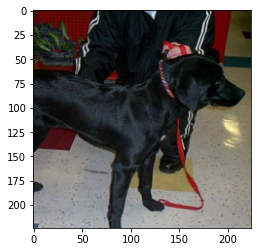

In [ ]:
show_image(*train_dataset.__getitem__(0))

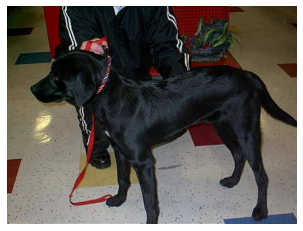

In [ ]:

img = Image.open(train_set[0])
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
dataloader_dict = {'train': train_dataloader, 'test': test_dataloader}

Model loading

In [ ]:
# Expired may use in the future test

# from collections import namedtuple
# import json
# results = []
# class Vgg16(torch.nn.Module):
#     def __init__(self):
#         super(Vgg16, self).__init__()
#         features = list(models.vgg16(pretrained = True).features)
#         avgpool = models.vgg16(pretrained = True).avgpool
#         # features的第3，8，15，22层分别是: relu1_2,relu2_2,relu3_3,relu4_3
#         classifier = list(models.vgg16(pretrained = True).classifier)
#         self.features = nn.ModuleList(features).eval() 
#         self.avgpool = avgpool.eval()
#         self.classifier = nn.ModuleList(classifier).eval()
        
#     def forward(self, x):
#         #results = []
#         global results
#         for ii,model in enumerate(self.features):
#             x = model(x)
#             if ii in {3,8,15,22,29}:
#                 results.append(x.detach().cpu().numpy())
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         for ii, model in enumerate(self.classifier):
#             x = model(x)
#             if ii in {1, 4}:
#                 results.append(x.detach().cpu().numpy())
        
#         # vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3', 'relu_1_classifier', 'relu_2_classifier'])
#         # # j = json.dumps(x._asdict())
#         # with open('data.json', 'w') as f:
#         #   json.dump(vgg_outputs(*results)._asdict(), f)


#         return x

In [ ]:
# VGG16 Model Loading
use_pretrained = True # label may change in following test
net = models.vgg16(pretrained=use_pretrained)
print(net)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
# Change the last layer to binary classfication
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

In [ ]:
for name, param in net.named_parameters():
  print(name)


features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [ ]:
# Specify The Layers for updating
params_to_update = []

update_params_name = ['features.0.weight', 'features.0.bias','classifier.6.weight', 'classifier.6.bias'] #TODO: change this to unfreeze the layer

for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

features.0.weight
features.0.bias
classifier.6.weight
classifier.6.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [ ]:
train_loss_dict1 = {} #store

In [ ]:
def train_model(net, dataloader_dict, criterion, optimizer, num_epoch, loss_dict):
    
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    net = net.to(device)
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        
        for phase in ['train', 'test']:
            _name = phase +str(epoch)
            loss_dict[_name] = []
            
            if phase == 'train':
                net.train()

            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            epoch_finish = 0
            
            for _id, (inputs, labels) in enumerate(tqdm(dataloader_dict[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    epoch_finish += len(preds)

                    if _id%10 == 6 :
                        curr_epoch_loss = epoch_loss / epoch_finish
                        curr_epoch_acc = epoch_corrects.double() / epoch_finish
                        loss_dict[_name].append((_id, curr_epoch_loss, curr_epoch_acc))

                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    net.load_state_dict(best_model_wts)
    return net


In [ ]:
# Train
# Change the last layer to binary classfication
num_epoch = 2 # batchsize to 32 will return high accuracy already
net = train_model(net, dataloader_dict, criterion, optimizer, num_epoch, train_loss_dict1)

Epoch 1/2
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train Loss: 0.0570 Acc: 0.9782



test Loss: 0.0375 Acc: 0.9866
Epoch 2/2
--------------------



train Loss: 0.0420 Acc: 0.9832



test Loss: 0.0350 Acc: 0.9862
Training complete in 8m 33s
Best val Acc: 0.986600


Save model

In [ ]:
#save model
torch.save(net,'model_ori_trained2.pkl')


In [ ]:
train_loss_dict1['train0']

[(6,
  0.47434595227241516,
  tensor(0.7946, device='cuda:0', dtype=torch.float64)),
 (16,
  0.2784149819875465,
  tensor(0.8934, device='cuda:0', dtype=torch.float64)),
 (26,
  0.21137551590800285,
  tensor(0.9213, device='cuda:0', dtype=torch.float64)),
 (36,
  0.17152874707873608,
  tensor(0.9392, device='cuda:0', dtype=torch.float64)),
 (46, 0.144693100765506, tensor(0.9495, device='cuda:0', dtype=torch.float64)),
 (56,
  0.12944629523707063,
  tensor(0.9534, device='cuda:0', dtype=torch.float64)),
 (66,
  0.11532354822604736,
  tensor(0.9580, device='cuda:0', dtype=torch.float64)),
 (76,
  0.10681771386608288,
  tensor(0.9614, device='cuda:0', dtype=torch.float64)),
 (86,
  0.09931877925563817,
  tensor(0.9648, device='cuda:0', dtype=torch.float64)),
 (96,
  0.09556881244265542,
  tensor(0.9655, device='cuda:0', dtype=torch.float64)),
 (106,
  0.09115307685858179,
  tensor(0.9670, device='cuda:0', dtype=torch.float64)),
 (116,
  0.08839842864176911,
  tensor(0.9677, device='cuda:0

In [ ]:
loss_curve = []
acc_curve = []
test_idx = []
for i in range(len(train_loss_dict1['train0'])):
  idx, loss_, acc = train_loss_dict1['train0'][i]
  test_idx.append(idx)
  loss_curve.append(loss_)
  acc_curve.append(acc.item())



import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (8,5)
plt.figure(dpi=100)

plt.plot(loss_curve, label='loss')
plt.plot(acc_curve, label='acc')
plt.legend()
plt.show()
  

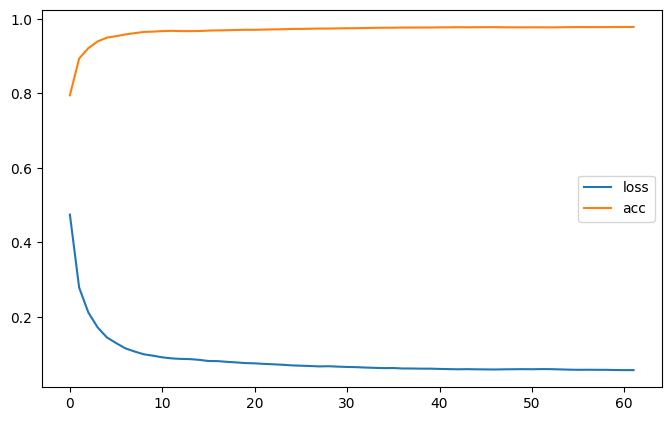

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (8,5)
plt.figure(dpi=100)

plt.plot(loss_curve, label='loss')
plt.plot(acc_curve, label='acc')
plt.legend()
plt.show()

In [ ]:
#load model
net_ori_trained = torch.load('model_ori_trained.pkl')

In [ ]:
# save to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp model_ori_trained2.pkl  drive/MyDrive

In [ ]:
def test_model(net_, dataloader_input):
    

    net_.eval()
        
    epoch_loss = 0.0
    epoch_corrects = 0
    epoch_finish = 0
    
    for _id, (inputs, labels) in enumerate(tqdm(dataloader_input)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()        
        outputs = net_(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item() * inputs.size(0)
        epoch_corrects += torch.sum(preds == labels.data)
        epoch_finish += len(preds)

            
    epoch_loss = epoch_loss / len(dataloader_input.dataset)
    epoch_acc = epoch_corrects.double() / len(dataloader_input.dataset)
    
    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
                



In [ ]:
# Is this model work?
test_model(net_ori_trained, test_dataloader)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Loss: 0.0324 Acc: 0.9872


Generate Adversarial examples


In [ ]:
visualize(ori_image_lst[-2], noises[-2][0], adv_image_lst[-2], eps, ori_label_lst[-2], adv_label_lst[-2], ori_prob[-2], adv_prob[-2] )